In [1]:
from pulp import *
from alb_tools import *
import itertools
from more_itertools import set_partitions
import numpy as np

# MDP model
taken from Markov decision process for multi-manned mixed-model assembly lines with walking workers Hasemi-Petroodi et. al. 2022

In [2]:
instance_names = ['SALBP_benchmark/small data set_n=20/instance_n=20_1.alb','SALBP_benchmark/small data set_n=20/instance_n=20_2.alb' ]
#instance_names = ['SALBP_benchmark/debugging_ds/instance_n=3_1.alb','SALBP_benchmark/debugging_ds/instance_n=3_2.alb' ]
test_instances = create_instance_pairs(instance_names)
NO_EQUIPMENT = 4
NO_S = 2
C_EM = 150
NO_MODELS = 2
TAKT_TIME = 200 #cadence to respect
MAX_L = 3 #maximum number of workers at a station
#STATION_MODEL_PICTURES  = {}

S_E = [(s, e ) for s in range(NO_S) for e in range(NO_EQUIPMENT)]
S_L = [(s , l) for s in range(NO_S) for l in range(1, MAX_L)]

NO_CONFIG = NO_MODELS ** NO_S #Number of possible line pictures

test_instances[0]= eliminate_tasks(test_instances[0], (.7,.8))
for i in range(NO_MODELS):
    test_instances[0][i]['cycle_time'] = TAKT_TIME
    test_instances[0][i]['c_em'] = C_EM
    test_instances[0][i]['max_workers'] = MAX_L

all_tasks = list_all_tasks(test_instances[0]) 

c_se, r_oe = generate_equipment(NO_EQUIPMENT,NO_S, all_tasks)
stations = list(range(NO_S))
models = list(range(NO_MODELS))
model_pairs = list(itertools.combinations(models, 2))
omega = []
enumerate_universe('', omega, NO_MODELS, NO_S)
actions = list(range(len(all_tasks) ** NO_S))
# equipment = list(range(NO_EQUIPMENT))
# workers = list(range(1, MAX_L+1))


In [3]:
print(test_instances)

[[{'num_tasks': 5, 'cycle_time': 200, 'order_strength': 0.268, 'task_times': {'3': 140, '4': 214, '13': 107, '19': 120, '20': 186}, 'precedence_relations': [('4', '19'), ('4', '20')], 'model_no': 0, 'c_em': 150, 'max_workers': 3}, {'num_tasks': 5, 'cycle_time': 200, 'order_strength': 0.3, 'task_times': {'3': 20, '4': 150, '13': 60, '19': 107, '20': 53}, 'precedence_relations': [('13', '19'), ('13', '20'), ('4', '13')], 'model_no': 1, 'c_em': 150, 'max_workers': 3}]]


/var/folders/6v/7nrd1rj91hx3tb4q5npbdf0w0000gn/T/ipykernel_94178/1903328287.py:6: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


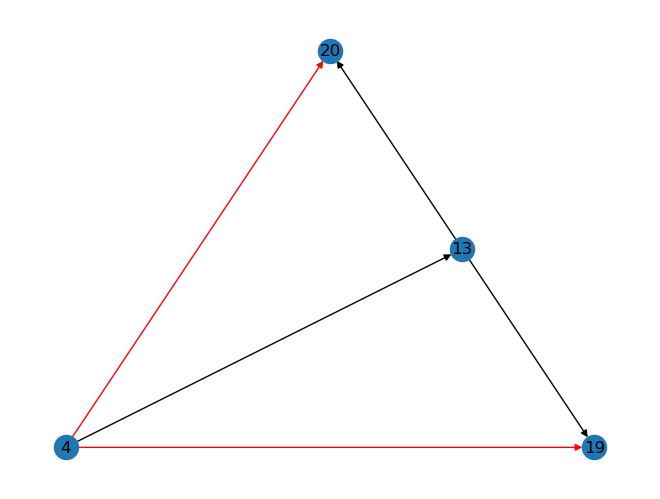

In [4]:
p_graph = nx.DiGraph()
p_graph.add_edges_from(test_instances[0][0]['precedence_relations'], color = 'r')
p_graph.add_edges_from(test_instances[0][1]['precedence_relations'], color= 'k')
colors = [p_graph[u][v]['color'] for u,v in p_graph.edges]
nx.draw_planar(p_graph, edge_color=colors, with_labels=True)
plt.tight_layout()
plt.savefig("precedence_graph.png", format="PNG" )

In [5]:
test_instances[0]

[{'num_tasks': 5,
  'cycle_time': 200,
  'order_strength': 0.268,
  'task_times': {'3': 140, '4': 214, '13': 107, '19': 120, '20': 186},
  'precedence_relations': [('4', '19'), ('4', '20')],
  'model_no': 0,
  'c_em': 150,
  'max_workers': 3},
 {'num_tasks': 5,
  'cycle_time': 200,
  'order_strength': 0.3,
  'task_times': {'3': 20, '4': 150, '13': 60, '19': 107, '20': 53},
  'precedence_relations': [('13', '19'), ('13', '20'), ('4', '13')],
  'model_no': 1,
  'c_em': 150,
  'max_workers': 3}]

In [6]:
feasible_partitions = {}

for model in models:
    partitions = []
    task_partitioning(partitions, [[] for _ in range(NO_S)], list(all_tasks), NO_S,  test_instances[0][model])
    feasible_partitions[f'model_{model}'] = partitions

In [7]:
feasible_partitions

{'model_0': [[['20', '13', '4'], ['19', '3']],
  [['20', '4', '19'], ['13', '3']],
  [['20', '4', '3'], ['13', '19']],
  [['20', '4'], ['13', '19', '3']],
  [['13', '4', '19', '3'], ['20']],
  [['13', '4', '19'], ['20', '3']],
  [['13', '4', '3'], ['20', '19']],
  [['13', '4'], ['20', '19', '3']],
  [['13', '3'], ['20', '4', '19']],
  [['4', '19', '3'], ['20', '13']],
  [['4', '19'], ['20', '13', '3']],
  [['4', '3'], ['20', '13', '19']],
  [['4'], ['20', '13', '19', '3']]],
 'model_1': [[['20', '13', '4', '19'], ['3']],
  [['20', '13', '4', '3'], ['19']],
  [['20', '13', '4'], ['19', '3']],
  [['13', '4', '19', '3'], ['20']],
  [['13', '4', '19'], ['20', '3']],
  [['13', '4', '3'], ['20', '19']],
  [['13', '4'], ['20', '19', '3']],
  [['4', '3'], ['20', '13', '19']],
  [['4'], ['20', '13', '19', '3']],
  [['3'], ['20', '13', '4', '19']]]}

## MDP State
### State variables
F_isd -- Equal to 1 when model i is located at station s in state d, 0 otherwise

P_osd -- equal to 1 if model 1 if task o has been already executed for the the model in station s when the sytem passed to state d, 0 otherwise


R_osa -- equal to 1 if action a performs task o on the model in station s



### Transistion variables
Tr_a_d_dprime -- probability to transistion from state d to state d' with action a


### Other parameters
q_as -- number of workers required in station s for action a






## STATE markov decision process

In [8]:
no_line_pictures = len(omega)
no_line_pictures

4

In [9]:
def create_model_histories(feasible_partitions, models, NO_S):
    model_histories = {}
    for model in models:
            feasible_histories = []
            for index, partition in enumerate(feasible_partitions[f'model_{model}']):
                feasible_history = {}
                feasible_history['index'] = index
                feasible_history['station_0'] = []
                completed_tasks = partition[0]
                for station in range(1,NO_S):
                    feasible_history[f'station_{station}'] = completed_tasks.copy()
                    completed_tasks = completed_tasks + partition[station]
                feasible_histories.append(feasible_history)
            model_histories[f'model_{model}'] = feasible_histories
    return model_histories
model_histories = create_model_histories(feasible_partitions,models, NO_S)
model_histories


{'model_0': [{'index': 0, 'station_0': [], 'station_1': ['20', '13', '4']},
  {'index': 1, 'station_0': [], 'station_1': ['20', '4', '19']},
  {'index': 2, 'station_0': [], 'station_1': ['20', '4', '3']},
  {'index': 3, 'station_0': [], 'station_1': ['20', '4']},
  {'index': 4, 'station_0': [], 'station_1': ['13', '4', '19', '3']},
  {'index': 5, 'station_0': [], 'station_1': ['13', '4', '19']},
  {'index': 6, 'station_0': [], 'station_1': ['13', '4', '3']},
  {'index': 7, 'station_0': [], 'station_1': ['13', '4']},
  {'index': 8, 'station_0': [], 'station_1': ['13', '3']},
  {'index': 9, 'station_0': [], 'station_1': ['4', '19', '3']},
  {'index': 10, 'station_0': [], 'station_1': ['4', '19']},
  {'index': 11, 'station_0': [], 'station_1': ['4', '3']},
  {'index': 12, 'station_0': [], 'station_1': ['4']}],
 'model_1': [{'index': 0,
   'station_0': [],
   'station_1': ['20', '13', '4', '19']},
  {'index': 1, 'station_0': [], 'station_1': ['20', '13', '4', '3']},
  {'index': 2, 'station

In [10]:
def create_D(omega, model_histories, NO_S):
    def create_picture_hist(picture, D, d, d_count, model_histories, current_station, no_s):
        if current_station >= no_s:
                d['index'] = d_count
                D.append(d)
                return d_count + 1
        if current_station == 0:
            d_copy = copy.deepcopy(d)
            d_copy[f'model_at_{current_station}'] = picture[current_station]
            d_copy[f'history_at_{current_station}'] = []
            d_count = create_picture_hist(picture, D, d_copy, d_count, model_histories, current_station + 1, no_s)
        else:
            possible_histories = (list(x) for x in set(tuple(sorted(history[f'station_{current_station}'])) for history in model_histories[f'model_{picture[current_station]}']))
            for history in possible_histories:
                d_copy = copy.deepcopy(d)
                d_copy[f'model_at_{current_station}'] = picture[current_station]
                d_copy[f'history_at_{current_station}'] = history
                d_count = create_picture_hist(picture, D, d_copy, d_count, model_histories, current_station + 1, no_s)
        return d_count
    D = []
    d_count = 0
    for picture in omega:
        picture_hist = []
        d_count = create_picture_hist(picture, picture_hist, {},d_count,  model_histories, 0, NO_S)
        #print('picture_hist', picture_hist)
        D = D + picture_hist
    return D

D = create_D(omega, model_histories, NO_S)

In [11]:
D

[{'model_at_0': '0',
  'history_at_0': [],
  'model_at_1': '0',
  'history_at_1': ['13', '3'],
  'index': 0},
 {'model_at_0': '0',
  'history_at_0': [],
  'model_at_1': '0',
  'history_at_1': ['3', '4'],
  'index': 1},
 {'model_at_0': '0',
  'history_at_0': [],
  'model_at_1': '0',
  'history_at_1': ['13', '19', '4'],
  'index': 2},
 {'model_at_0': '0',
  'history_at_0': [],
  'model_at_1': '0',
  'history_at_1': ['19', '20', '4'],
  'index': 3},
 {'model_at_0': '0',
  'history_at_0': [],
  'model_at_1': '0',
  'history_at_1': ['13', '3', '4'],
  'index': 4},
 {'model_at_0': '0',
  'history_at_0': [],
  'model_at_1': '0',
  'history_at_1': ['19', '4'],
  'index': 5},
 {'model_at_0': '0',
  'history_at_0': [],
  'model_at_1': '0',
  'history_at_1': ['13', '20', '4'],
  'index': 6},
 {'model_at_0': '0',
  'history_at_0': [],
  'model_at_1': '0',
  'history_at_1': ['13', '4'],
  'index': 7},
 {'model_at_0': '0',
  'history_at_0': [],
  'model_at_1': '0',
  'history_at_1': ['4'],
  'index'

In [12]:
len(D)

46

In [13]:
def calculate_time_and_workers(tasks, instance, model, takt_time, max_workers):
    total_time = 0
    for task in tasks:
        total_time += instance[model]['task_times'][task]
    workers = 1

    while total_time / workers > takt_time:
        workers += 1
        if workers > max_workers:
             return total_time, None, None
    reduced_time = total_time / workers
    return total_time, reduced_time, workers

def create_A(D, model_histories, instances, TAKT_TIME, MAX_L, NO_S):
    def create_action(d, A, a, a_count, instance, takt_time, max_workers,  model_histories, current_station, no_s):

        if current_station == no_s:
                a_copy = copy.deepcopy(a)
                a_copy['state_index'] = d['index']
                a_copy['action_index'] = str(d['index']) + '_' + str(a_count)
                a_copy['total_workers'] = sum(a_copy[f'workers_at_{station}'] for station in range(no_s))
                A.append(a_copy)
                return a_count + 1
        #Stop exploring branch if the previous statement was infeasible
        if current_station > 0 and not a[f'reduced_time_at_{current_station-1}']:
            return a_count
        for history in model_histories[f'model_{d[f"model_at_{current_station}"]}']:
            if d[f'history_at_{current_station}'] == history[f'station_{current_station}']:
                a_copy = copy.deepcopy(a)
                model_at_station = d[f'model_at_{current_station}']
                a_copy[f'model_at_{current_station}'] = model_at_station
                if current_station < no_s - 1:
                    a_copy[f'history_at_{current_station}'] = d[f'history_at_{current_station}']
                    a_copy[f'action_at_{current_station}'] =list(set(history[f'station_{current_station + 1}']) - set(d[f'history_at_{current_station}'])  )
                else:
                    a_copy[f'history_at_{current_station}'] = d[f'history_at_{current_station}']
                    a_copy[f'action_at_{current_station}'] =list(set(all_tasks) - set(d[f'history_at_{current_station}']))
                a_copy[f'total_task_time_at_{current_station}'], a_copy[f'reduced_time_at_{current_station}'], a_copy[f'workers_at_{current_station}'] = calculate_time_and_workers(a_copy[f'action_at_{current_station}'], instance, int(model_at_station), takt_time, max_workers)

                a_count = create_action(d, A, a_copy, a_count,  instance, takt_time, max_workers,  model_histories, current_station + 1, no_s)
        return a_count

    A = []
    a_count = 0
    #create action(s) for each state
    for d in D:
        action = []
        a_count = create_action(d, action, {}, a_count, instances, TAKT_TIME, MAX_L, model_histories, 0, NO_S)
        A = A + action
    return A

A = create_A(D, model_histories, test_instances[0], TAKT_TIME, MAX_L, NO_S)


In [14]:
def state_transistion_probability(action, current_state, next_state, NO_S, entry_probs = (.4, .6)):
    '''Given an action, gives the probability of going from current_state to next_state '''
    #Can only go to states who share models and history between station n and n+1
    for station in range(NO_S-1):
        if current_state['history_at_' + str(station)] + action['action_at_' + str(station)] != next_state['history_at_' + str(station+1)] :
            return 0
        elif current_state['model_at_' + str(station)] != next_state['model_at_' + str(station+1)]:
            return 0
    #TODO modify the entry probabilities if we have constraints on the number of models of a given product in a line
    #returns the likelihood of going from current_state to next_state given action. This just depends on what model enters the first station
    return entry_probs[int(next_state['model_at_0'])]



# MDP MILP
whew, finally

### Decision Variables

W_se -- 1 if equipment e is chosen for station s, 0 otherwise

X_ad -- probability of taking action a in state d

### Other variables
y_asoi -- 1 if task o is at station s for model i during action a

In [15]:
#Parameters
WORKER_COST= 200

In [16]:

#Decision Variables
X_ad =LpVariable.dicts('X_ad', (action['action_index'] for action in A), lowBound=0, upBound=1, cat=LpContinuous )
W_se = LpVariable.dicts('W_se', (S_E), lowBound=0, upBound=1, cat=LpBinary )

In [17]:
prob = LpProblem("MDP", LpMinimize)
prob += lpSum([X_ad[action['action_index']] * WORKER_COST * action['total_workers'] for action in A] + [W_se[s,e] * c_se[s,e] for s,e in S_E]), "Total Cost"

for d_prime in D:
    d_prime_indices = [action['action_index'] for action in A if action['state_index'] == d_prime['index']]                                                                  
    #constraint 3
    prob += lpSum([X_ad[action['action_index']] * state_transistion_probability(action, D[int(action['state_index'])], d_prime, NO_S) for action in A]) == lpSum([X_ad[action] for action in d_prime_indices]), f"State_{d_prime['index']}_probability"
#constraint 4
prob += lpSum([X_ad[action['action_index']] for action in A]) == 1, "Sum of probabilities"
for station in range(NO_S):
    for o, task in enumerate(all_tasks):
        for model in range(NO_MODELS):
            for d in D:
                for a in A:
                    if d['index'] == a['state_index'] and d['model_at_' + str(station)] ==  a['model_at_' + str(station)] and task in a['action_at_' + str(station)]:
                        y_asoi = 1
                        #constraint 5
                        prob += y_asoi * X_ad[a['action_index']] <= lpSum([r_oe[o][equipment] * W_se[station, equipment]  for equipment in range(NO_EQUIPMENT)]), f"equipment_for_o_{task}_i_{model}_s_{station}_d_{d['index']}_a_{a['action_index']}"


{'model_at_0': '0', 'history_at_0': [], 'model_at_1': '0', 'history_at_1': ['13', '3'], 'index': 0}

{'model_at_0': '0', 'history_at_0': [], 'model_at_1': '0', 'history_at_1': ['3', '4'], 'index': 1}

{'model_at_0': '0', 'history_at_0': [], 'model_at_1': '0', 'history_at_1': ['13', '19', '4'], 'index': 2}

{'model_at_0': '0', 'history_at_0': [], 'model_at_1': '0', 'history_at_1': ['19', '20', '4'], 'index': 3}

{'model_at_0': '0', 'history_at_0': [], 'model_at_1': '0', 'history_at_1': ['13', '3', '4'], 'index': 4}

{'model_at_0': '0', 'history_at_0': [], 'model_at_1': '0', 'history_at_1': ['19', '4'], 'index': 5}

{'model_at_0': '0', 'history_at_0': [], 'model_at_1': '0', 'history_at_1': ['13', '20', '4'], 'index': 6}

{'model_at_0': '0', 'history_at_0': [], 'model_at_1': '0', 'history_at_1': ['13', '4'], 'index': 7}

{'model_at_0': '0', 'history_at_0': [], 'model_at_1': '0', 'history_at_1': ['4'], 'index': 8}
current_state {'model_at_0': '0', 'history_at_0': [], 'model_at_1': '0', 'h

In [18]:
print(len(A))
A

161


[{'model_at_0': '0',
  'history_at_0': [],
  'action_at_0': ['4', '20', '13'],
  'total_task_time_at_0': 507,
  'reduced_time_at_0': 169.0,
  'workers_at_0': 3,
  'model_at_1': '0',
  'history_at_1': ['13', '3'],
  'action_at_1': ['4', '19', '20'],
  'total_task_time_at_1': 520,
  'reduced_time_at_1': 173.33333333333334,
  'workers_at_1': 3,
  'state_index': 0,
  'action_index': '0_0',
  'total_workers': 6},
 {'model_at_0': '0',
  'history_at_0': [],
  'action_at_0': ['4', '19', '20'],
  'total_task_time_at_0': 520,
  'reduced_time_at_0': 173.33333333333334,
  'workers_at_0': 3,
  'model_at_1': '0',
  'history_at_1': ['13', '3'],
  'action_at_1': ['4', '19', '20'],
  'total_task_time_at_1': 520,
  'reduced_time_at_1': 173.33333333333334,
  'workers_at_1': 3,
  'state_index': 0,
  'action_index': '0_1',
  'total_workers': 6},
 {'model_at_0': '0',
  'history_at_0': [],
  'action_at_0': ['4', '3', '20'],
  'total_task_time_at_0': 540,
  'reduced_time_at_0': 180.0,
  'workers_at_0': 3,
  '

In [19]:
prob

MDP:
MINIMIZE
221*W_se_(0,_0) + 281*W_se_(0,_1) + 283*W_se_(0,_2) + 183*W_se_(0,_3) + 164*W_se_(1,_0) + 184*W_se_(1,_1) + 266*W_se_(1,_2) + 283*W_se_(1,_3) + 1200*X_ad_0_0 + 1200*X_ad_0_1 + 1000*X_ad_0_10 + 1000*X_ad_0_11 + 1000*X_ad_0_12 + 1200*X_ad_0_2 + 1000*X_ad_0_3 + 1200*X_ad_0_4 + 1200*X_ad_0_5 + 1200*X_ad_0_6 + 1000*X_ad_0_7 + 1000*X_ad_0_8 + 1200*X_ad_0_9 + 1000*X_ad_12_39 + 1000*X_ad_12_40 + 1000*X_ad_12_41 + 800*X_ad_12_42 + 1000*X_ad_12_43 + 1000*X_ad_12_44 + 1000*X_ad_12_45 + 800*X_ad_12_46 + 800*X_ad_12_47 + 1000*X_ad_12_48 + 800*X_ad_12_49 + 800*X_ad_12_50 + 800*X_ad_12_51 + 1000*X_ad_13_52 + 1000*X_ad_13_53 + 1000*X_ad_13_54 + 800*X_ad_13_55 + 1000*X_ad_13_56 + 1000*X_ad_13_57 + 1000*X_ad_13_58 + 800*X_ad_13_59 + 800*X_ad_13_60 + 1000*X_ad_13_61 + 800*X_ad_13_62 + 800*X_ad_13_63 + 800*X_ad_13_64 + 1000*X_ad_17_65 + 1000*X_ad_17_66 + 1000*X_ad_17_67 + 800*X_ad_17_68 + 1000*X_ad_17_69 + 1000*X_ad_17_70 + 1000*X_ad_17_71 + 800*X_ad_17_72 + 800*X_ad_17_73 + 1000*X_ad_17_74 

In [20]:
XPRESS_PY()

In [21]:
prob.solve(solver=XPRESS_PY(export='model.lp'))

Using the license file found in your Xpress installation. If you want to use this license and no longer want to see this message, use the following code before using the xpress module:
  xpress.init('/Applications/FICO Xpress/xpressmp/bin/xpauth.xpr')
FICO Xpress v9.0.3, Community, solve started 14:14:22, Jun 7, 2023
Heap usage: 1289KB (peak 1321KB, 521KB system)
Minimizing MILP noname using up to 8 threads and up to 8192MB memory, with these control settings:
OUTPUTLOG = 1
Original problem has:
      1991 rows          169 cols         9695 elements         8 entities
Presolved problem has:
       145 rows           32 cols          655 elements         8 entities
LP relaxation tightened
Presolve finished in 0 seconds
Heap usage: 1118KB (peak 2364KB, 521KB system)

Coefficient range                    original                 solved        
  Coefficients   [min,max] : [ 4.00e-01,  1.00e+00] / [ 1.00e-01,  1.75e+00]
  RHS and bounds [min,max] : [ 1.00e+00,  1.00e+00] / [ 2.50e-01,  1.

1

In [22]:
for index, row in prob.constraints.items():
    print(row.name, ":", row.pi)

State_0_probability : None
State_1_probability : None
State_2_probability : None
State_3_probability : None
State_4_probability : None
State_5_probability : None
State_6_probability : None
State_7_probability : None
State_8_probability : None
State_9_probability : None
State_10_probability : None
State_11_probability : None
State_12_probability : None
State_13_probability : None
State_14_probability : None
State_15_probability : None
State_16_probability : None
State_17_probability : None
State_18_probability : None
State_19_probability : None
State_20_probability : None
State_21_probability : None
State_22_probability : None
State_23_probability : None
State_24_probability : None
State_25_probability : None
State_26_probability : None
State_27_probability : None
State_28_probability : None
State_29_probability : None
State_30_probability : None
State_31_probability : None
State_32_probability : None
State_33_probability : None
State_34_probability : None
State_35_probability : None
St

In [23]:
for v in prob.variables():

    print(v.name, v.varValue)

W_se_(0,_0) -0.0
W_se_(0,_1) -0.0
W_se_(0,_2) -0.0
W_se_(0,_3) 1.0
W_se_(1,_0) 1.0
W_se_(1,_1) -5.551115123125783e-17
W_se_(1,_2) -0.0
W_se_(1,_3) -0.0
X_ad_0_0 0.0
X_ad_0_1 0.0
X_ad_0_10 0.0
X_ad_0_11 0.0
X_ad_0_12 0.0
X_ad_0_2 0.0
X_ad_0_3 0.0
X_ad_0_4 0.0
X_ad_0_5 0.0
X_ad_0_6 0.0
X_ad_0_7 0.0
X_ad_0_8 0.0
X_ad_0_9 0.0
X_ad_12_39 0.0
X_ad_12_40 0.0
X_ad_12_41 0.0
X_ad_12_42 0.0
X_ad_12_43 0.0
X_ad_12_44 0.0
X_ad_12_45 0.0
X_ad_12_46 0.0
X_ad_12_47 0.0
X_ad_12_48 0.0
X_ad_12_49 0.0
X_ad_12_50 0.0
X_ad_12_51 0.0
X_ad_13_52 0.0
X_ad_13_53 0.0
X_ad_13_54 0.0
X_ad_13_55 0.0
X_ad_13_56 0.0
X_ad_13_57 0.0
X_ad_13_58 0.0
X_ad_13_59 0.0
X_ad_13_60 0.0
X_ad_13_61 0.0
X_ad_13_62 0.0
X_ad_13_63 0.0
X_ad_13_64 -5.551115123125783e-17
X_ad_17_65 0.0
X_ad_17_66 0.0
X_ad_17_67 0.0
X_ad_17_68 0.0
X_ad_17_69 0.0
X_ad_17_70 0.0
X_ad_17_71 0.0
X_ad_17_72 0.0
X_ad_17_73 0.0
X_ad_17_74 0.0
X_ad_17_75 0.0
X_ad_17_76 0.0
X_ad_17_77 0.24000000000000002
X_ad_19_78 0.0
X_ad_19_79 0.0
X_ad_19_80 0.0
X_ad_19_81 